# **DWI Exploration** 

## Introduction to diffusion MRI analysis with DIPY


This tutorial teaches you diffusion MRI analysis from scratch, assuming no prior
knowledge. By the end, you'll understand:
- What diffusion MRI data looks like
- How water movement reveals brain structure
- How to process and analyze this data
- How to extract meaningful features



✓ All libraries loaded successfully!

CHAPTER 1: UNDERSTANDING DIFFUSION MRI DATA

Imagine you could see how water molecules move in your brain. In some areas,
like white matter tracts (highways connecting brain regions), water moves
preferentially along the fibers. In other areas, like gray matter, water
moves more freely in all directions.

Diffusion MRI captures this water movement, allowing us to:
1. Map the "highways" of the brain (white matter tracts)
2. Measure tissue microstructure
3. Detect abnormalities in brain connectivity


CHAPTER 2: LOADING YOUR FIRST BRAIN SCAN

✓ Data loaded successfully!

--------------------------------------------------------------------------------
UNDERSTANDING THE DATA SHAPE
--------------------------------------------------------------------------------

Your brain scan has shape: (81, 106, 76, 160)

Let's break this down:
- First dimension  (x): 81 slices from left to right
- Second dimension (y): 106 slices from back to front  
- Third dimensi

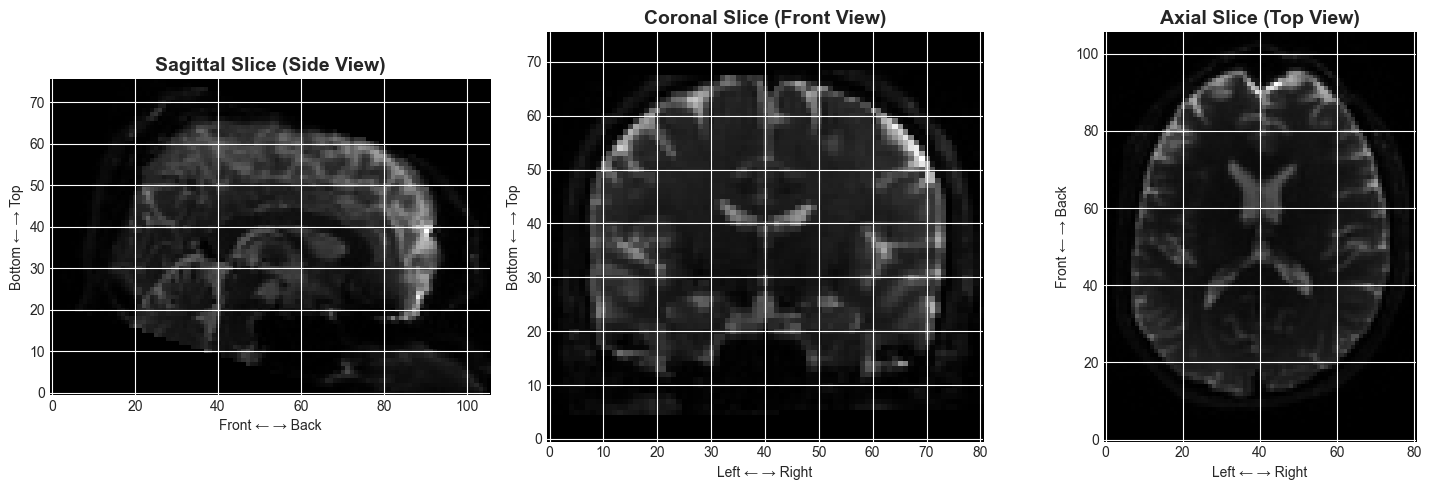


CHAPTER 4: UNDERSTANDING DIFFUSION DIRECTIONS

The gradient table (gtab) contains information about how we measured diffusion:

b-values (diffusion strength):
- b=0: No diffusion weighting (just shows anatomy)
- b>0: Diffusion weighted (shows water movement)

Your data has:
- Number of directions measured: 160
- Unique b-values: [   0. 2000.] s/mm²
- Number of b=0 images: 10
- Number of diffusion weighted images: 150

✓ Saved: 02_gradient_directions.png


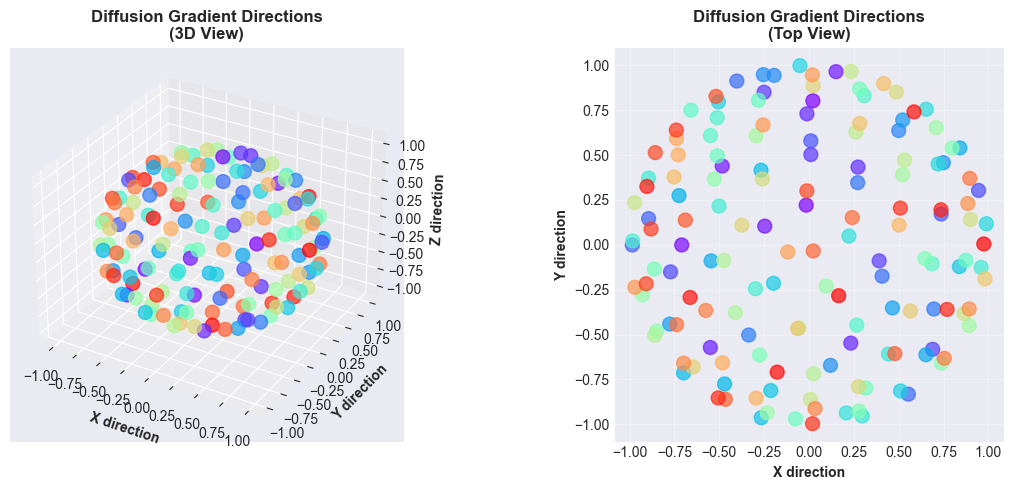


These arrows show the directions we measured water movement.
We measure in many directions to fully characterize how water diffuses.


CHAPTER 5: ISOLATING THE BRAIN

Not all voxels contain brain tissue - some are just air or skull.
We create a "mask" to identify which voxels are actually brain.
This speeds up analysis and improves accuracy.


Creating brain mask (this takes ~30 seconds)...

✓ Brain mask created!

Statistics:
- Total voxels in image: 652,536
- Brain voxels: 185,743
- Brain coverage: 28.5%
- Non-brain voxels removed: 466,793

✓ Saved: 03_brain_mask.png


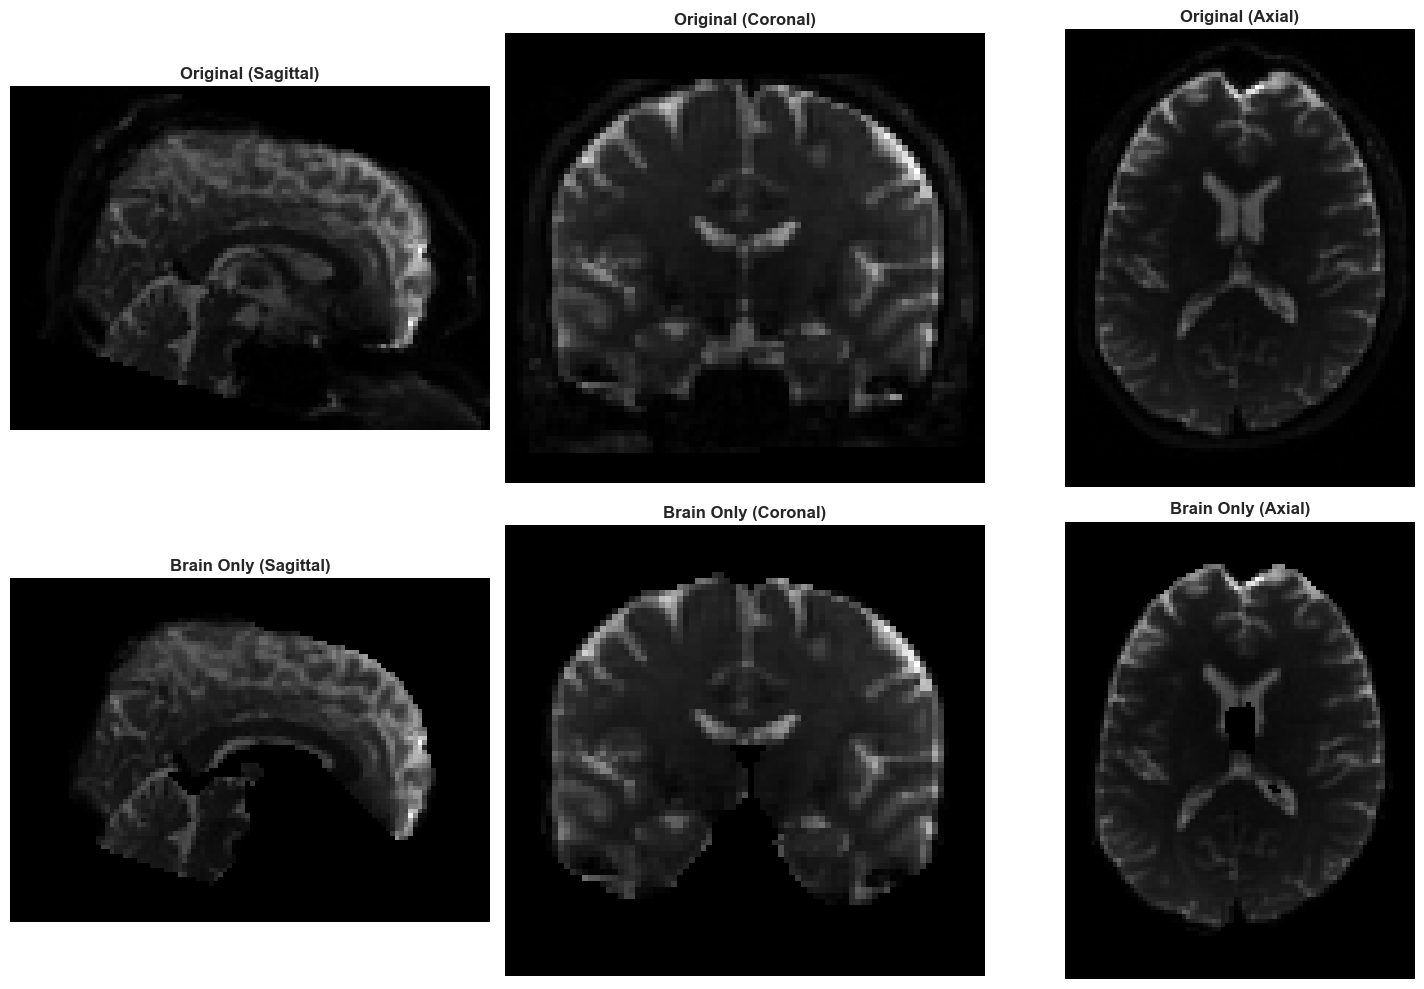


CHAPTER 6: MEASURING WATER MOVEMENT WITH DTI

DTI (Diffusion Tensor Imaging) is a model that describes how water moves.
Think of it like measuring the shape of water diffusion at each brain voxel:

- In cerebrospinal fluid: water moves equally in all directions (sphere)
- In white matter fibers: water moves mainly along the fiber (cigar shape)
- In crossing fibers: water has a more complex pattern

We'll compute several maps that quantify this movement.


Fitting DTI model (this takes ~1 minute)...
✓ DTI metrics computed!
✓ Saved: 04_dti_metrics.png


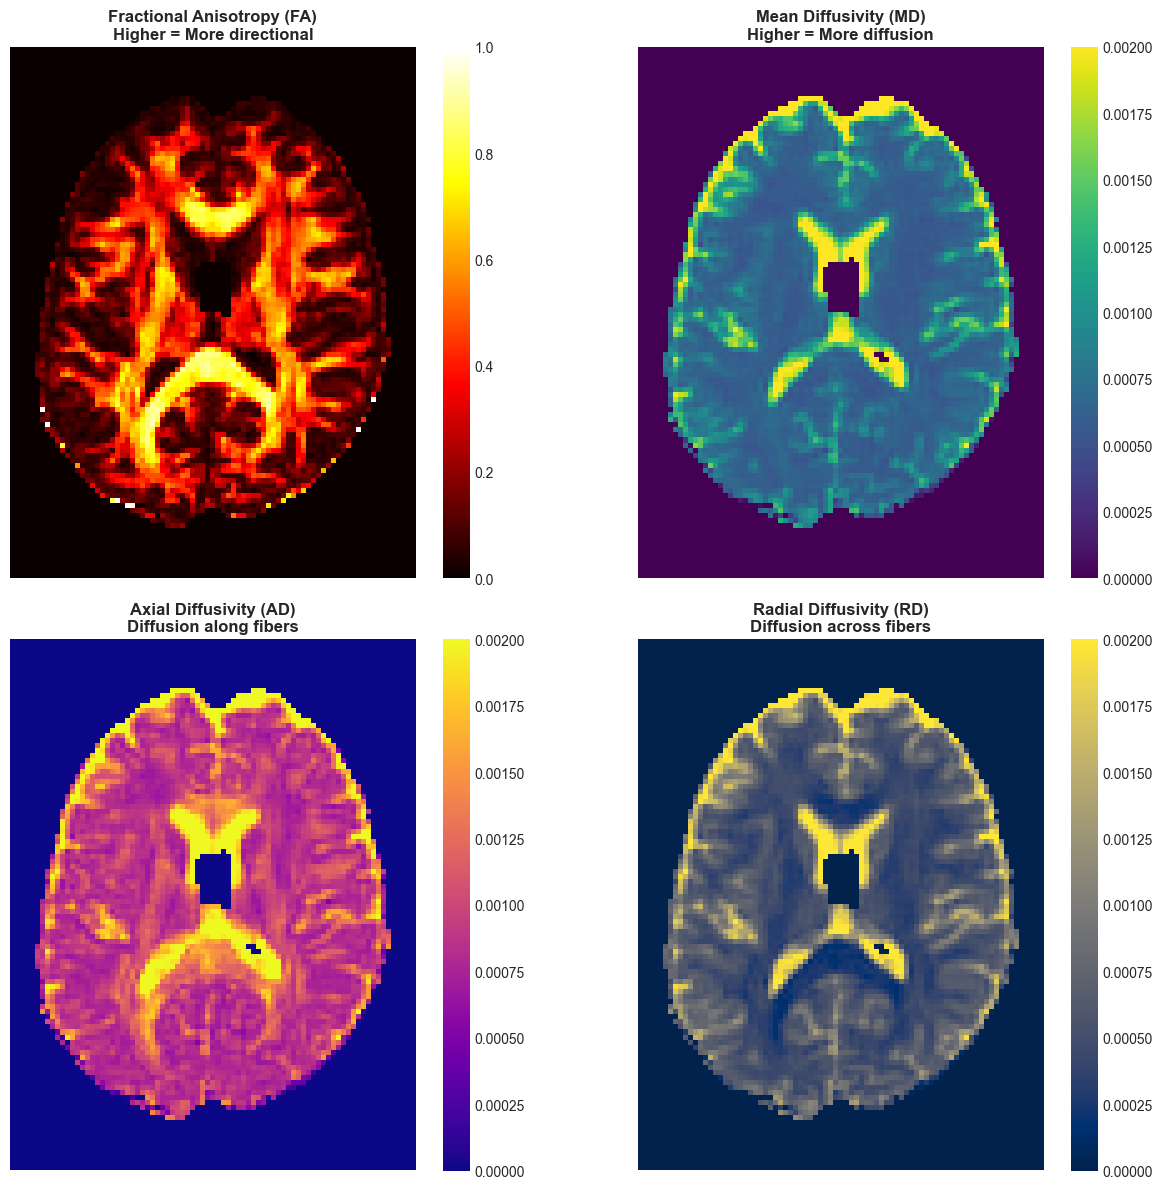


WHAT DO THESE MAPS MEAN?

FA (Fractional Anisotropy): 0 to 1
- High FA (red/white): Water moves in one main direction (organized fibers)
- Low FA (dark): Water moves equally in all directions (less organized)
- White matter tracts have high FA

MD (Mean Diffusivity): mm²/s
- How fast water diffuses on average
- High in CSF (free water), low in tissue

AD (Axial Diffusivity): mm²/s  
- Diffusion along the main fiber direction
- Sensitive to axonal integrity

RD (Radial Diffusivity): mm²/s
- Diffusion perpendicular to fibers
- Sensitive to myelin content


--------------------------------------------------------------------------------
DTI STATISTICS (in white matter where FA > 0.2)
--------------------------------------------------------------------------------
White matter voxels: 77,585 (41.8% of brain)

FA:  mean = 0.421, std = 0.164
MD:  mean = 0.000636 mm²/s
AD:  mean = 0.000953 mm²/s
RD:  mean = 0.000478 mm²/s

CHAPTER 7: VISUALIZING FIBER DIRECTIONS

We can color-code the FA map

C:\Users\yucca\AppData\Local\Temp\ipykernel_11124\1918028110.py:403: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved: 05_color_fa.png


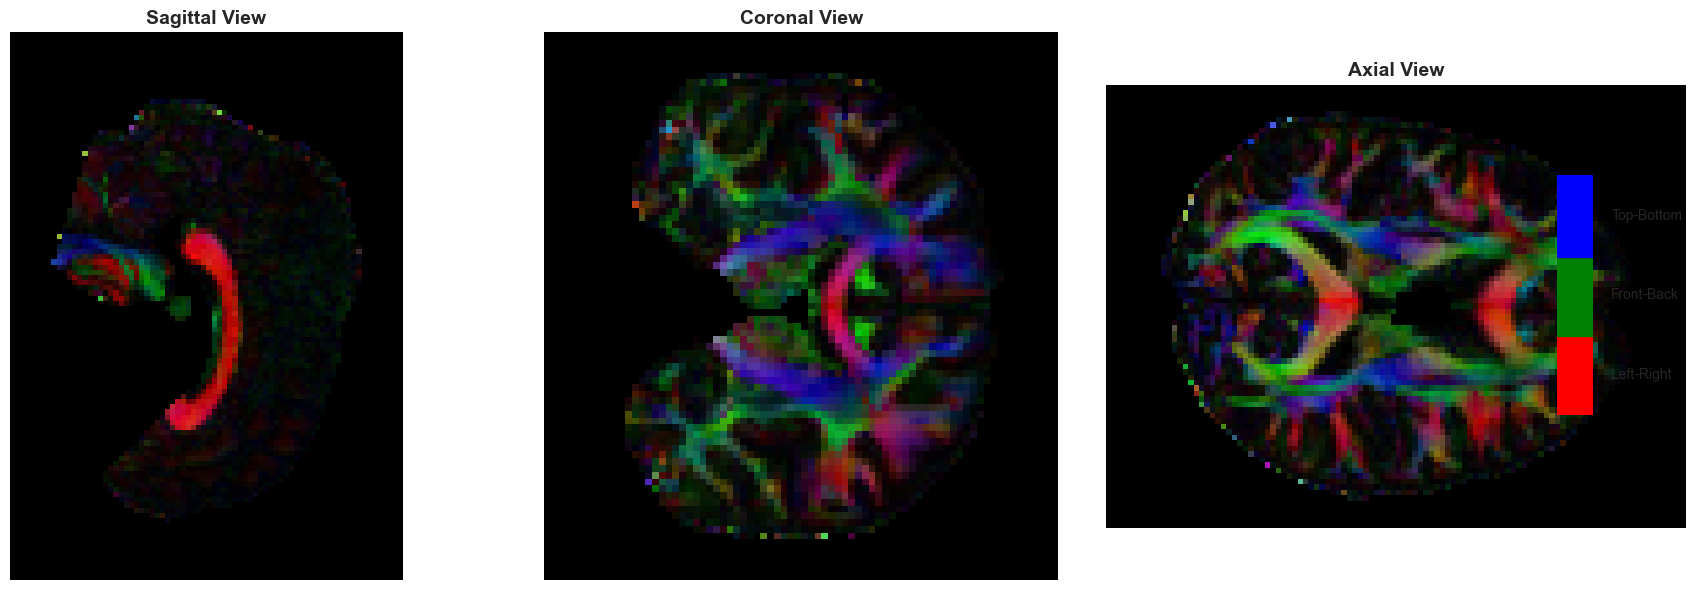


CHAPTER 8: DETECTING CROSSING FIBERS WITH CSD

DTI has a limitation: it assumes water moves in only ONE main direction per voxel.
But many brain regions have CROSSING fibers!

CSD (Constrained Spherical Deconvolution) solves this by:
1. Estimating the "response" of a single fiber bundle
2. Finding where multiple fiber bundles cross
3. Measuring fiber orientation at each voxel

This is more advanced but gives us better information about complex fiber patterns.


Step 1: Estimating fiber response function...
✓ Response function estimated (eigenvalue ratio: 0.215)
  Response eigenvalues: [0.00139919 0.0003007  0.0003007 ]

Step 2: Fitting CSD model (this takes ~2 minutes)...
✓ CSD model fitted!

Step 3: Finding fiber directions...
✓ Fiber directions computed!
✓ Saved: 06_csd_analysis.png


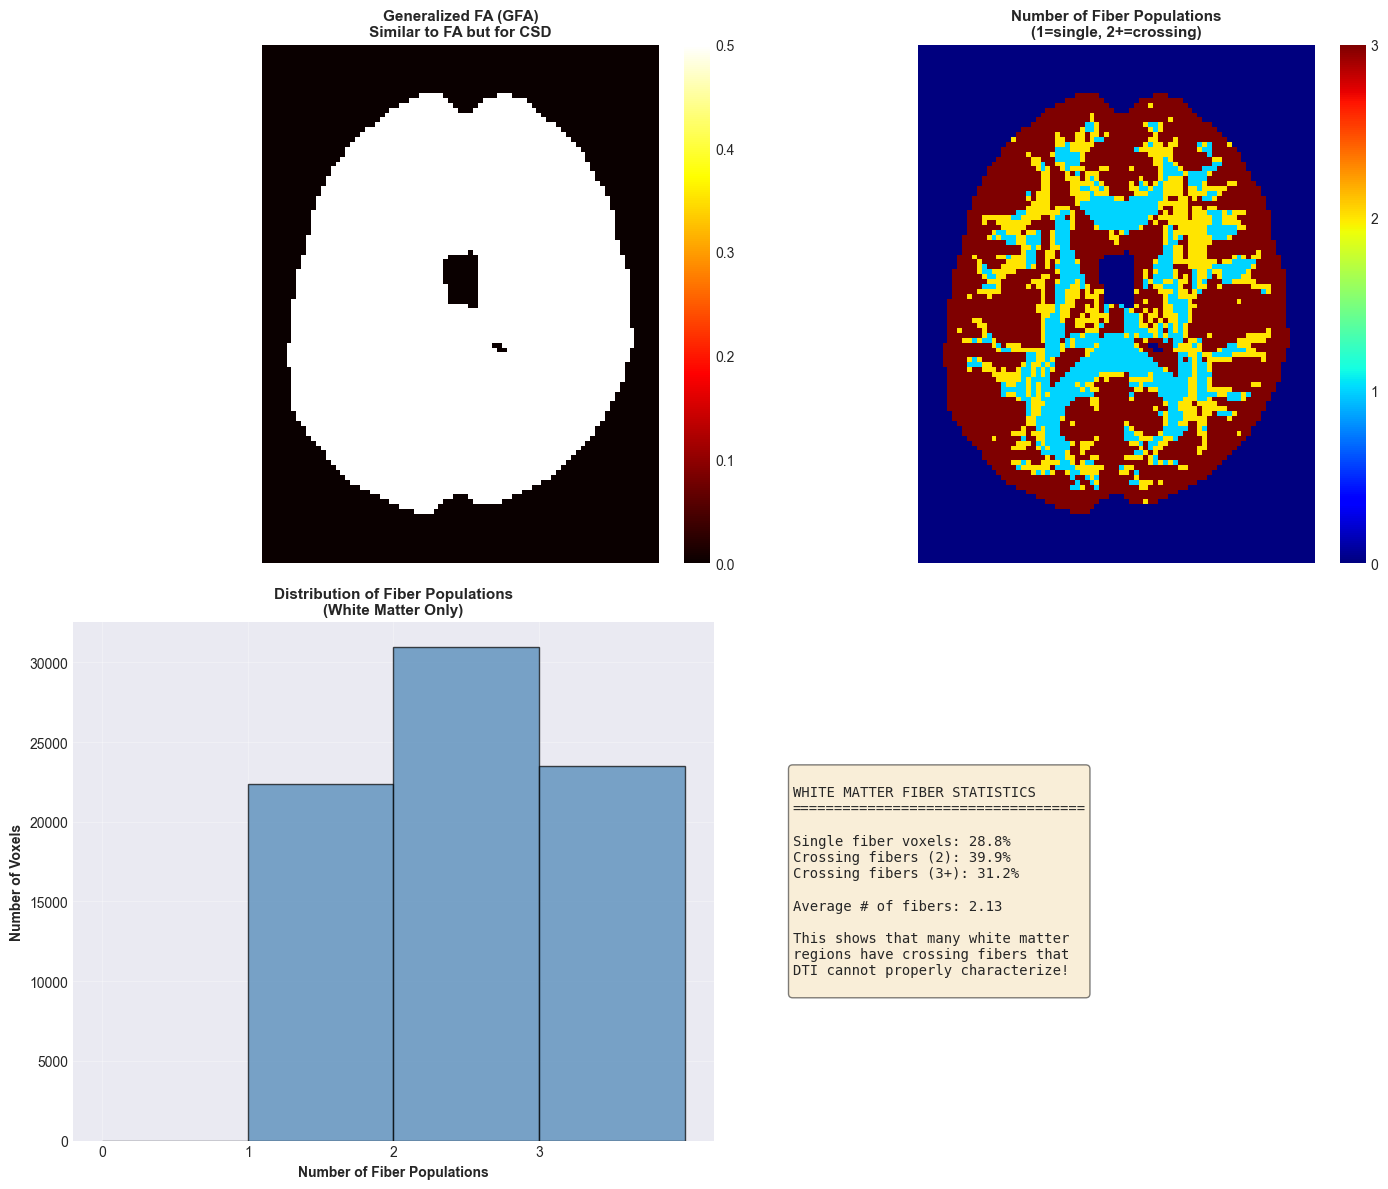


🎉 CONGRATULATIONS! YOU'VE COMPLETED THE TUTORIAL!

WHAT YOU'VE LEARNED:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. BASICS
   ✓ What diffusion MRI data looks like (4D: x, y, z, directions)
   ✓ How to visualize brain slices
   ✓ Understanding gradient directions

2. PREPROCESSING
   ✓ Creating brain masks to focus on brain tissue
   ✓ Why masking improves analysis speed and accuracy

3. DTI (DIFFUSION TENSOR IMAGING)
   ✓ FA: How directional is water movement?
   ✓ MD: How much water movement overall?
   ✓ AD/RD: Movement along vs across fibers
   ✓ Color-coded fiber direction maps

4. ADVANCED METHODS (CSD)
   ✓ Detecting crossing fibers
   ✓ Multiple fiber populations per voxel
   ✓ More accurate fiber orientation estimation

NEXT STEPS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. TRACTOGRAPHY
   - Track fiber pathways through the brain
   - Build connectivity networks
   - Study brain wiring

2. STATISTIC

In [18]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from mpl_toolkits.mplot3d import Axes3D
import os

# DIPY imports
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.reconst import dti
from dipy.reconst.csdeconv import auto_response_ssst, ConstrainedSphericalDeconvModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

# Create output directory
os.makedirs('./dwi_tutorial_output', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
print("✓ All libraries loaded successfully!\n")

################################################################################
# CHAPTER 1: WHAT IS DIFFUSION MRI?
################################################################################
print("="*80)
print("CHAPTER 1: UNDERSTANDING DIFFUSION MRI DATA")
print("="*80)
print("""
Imagine you could see how water molecules move in your brain. In some areas,
like white matter tracts (highways connecting brain regions), water moves
preferentially along the fibers. In other areas, like gray matter, water
moves more freely in all directions.

Diffusion MRI captures this water movement, allowing us to:
1. Map the "highways" of the brain (white matter tracts)
2. Measure tissue microstructure
3. Detect abnormalities in brain connectivity
""")

################################################################################
# CHAPTER 2: LOADING YOUR FIRST BRAIN SCAN
################################################################################
print("\n" + "="*80)
print("CHAPTER 2: LOADING YOUR FIRST BRAIN SCAN")
print("="*80)

print("\nDownloading example brain data (this may take a minute)...")
fetch_stanford_hardi()
hardi_img, gtab = read_stanford_hardi()
data = hardi_img.get_fdata()
affine = hardi_img.affine

print("✓ Data loaded successfully!")
print("\n" + "-"*80)
print("UNDERSTANDING THE DATA SHAPE")
print("-"*80)
print(f"""
Your brain scan has shape: {data.shape}

Let's break this down:
- First dimension  (x): {data.shape[0]} slices from left to right
- Second dimension (y): {data.shape[1]} slices from back to front  
- Third dimension  (z): {data.shape[2]} slices from bottom to top
- Fourth dimension    : {data.shape[3]} different measurements

Think of it like this:
- The first 3 numbers define a 3D grid covering the brain
- Each point in this grid is called a "voxel" (like a 3D pixel)
- At each voxel, we took {data.shape[3]} measurements in different directions
""")

# Calculate basic statistics
print("\n" + "-"*80)
print("DATA STATISTICS")
print("-"*80)
voxel_volume = np.prod(hardi_img.header.get_zooms()[:3])
brain_volume_mm3 = np.prod(data.shape[:3]) * voxel_volume
brain_volume_ml = brain_volume_mm3 / 1000

print(f"Total number of voxels: {np.prod(data.shape[:3]):,}")
print(f"Voxel size: {hardi_img.header.get_zooms()[:3]} mm³")
print(f"Approximate brain volume: {brain_volume_ml:.1f} mL")
print(f"Data size in memory: {data.nbytes / (1024**2):.1f} MB")

################################################################################
# CHAPTER 3: VISUALIZING BRAIN SLICES
################################################################################
print("\n" + "="*80)
print("CHAPTER 3: VISUALIZING BRAIN SLICES")
print("="*80)

print("""
A brain scan is 3D, but we view it by looking at 2D slices.
Let's visualize slices through the middle of the brain in three directions.
""")

# Get the middle slice in each direction
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

# Use the first volume (b=0, no diffusion weighting)
# This shows brain anatomy most clearly
b0_volume = data[:, :, :, 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sagittal (side view)
axes[0].imshow(b0_volume[mid_x, :, :].T, cmap='gray', origin='lower')
axes[0].set_title('Sagittal Slice (Side View)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Front ← → Back')
axes[0].set_ylabel('Bottom ← → Top')
axes[0].axis('on')

# Coronal (front view)
axes[1].imshow(b0_volume[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title('Coronal Slice (Front View)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Left ← → Right')
axes[1].set_ylabel('Bottom ← → Top')
axes[1].axis('on')

# Axial (top view)
axes[2].imshow(b0_volume[:, :, mid_z].T, cmap='gray', origin='lower')
axes[2].set_title('Axial Slice (Top View)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Left ← → Right')
axes[2].set_ylabel('Front ← → Back')
axes[2].axis('on')

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/01_brain_slices.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 01_brain_slices.png")
plt.show()

################################################################################
# CHAPTER 4: UNDERSTANDING DIFFUSION DIRECTIONS
################################################################################
print("\n" + "="*80)
print("CHAPTER 4: UNDERSTANDING DIFFUSION DIRECTIONS")
print("="*80)

print(f"""
The gradient table (gtab) contains information about how we measured diffusion:

b-values (diffusion strength):
- b=0: No diffusion weighting (just shows anatomy)
- b>0: Diffusion weighted (shows water movement)

Your data has:
- Number of directions measured: {len(gtab.bvals)}
- Unique b-values: {np.unique(gtab.bvals)} s/mm²
- Number of b=0 images: {np.sum(gtab.b0s_mask)}
- Number of diffusion weighted images: {np.sum(~gtab.b0s_mask)}
""")

# Visualize gradient directions on a sphere
fig = plt.figure(figsize=(12, 5))

# 3D sphere plot
ax1 = fig.add_subplot(121, projection='3d')
bvecs = gtab.bvecs[~gtab.b0s_mask]  # Get only diffusion-weighted directions
ax1.scatter(bvecs[:, 0], bvecs[:, 1], bvecs[:, 2], 
           c=range(len(bvecs)), cmap='rainbow', s=100, alpha=0.7)
ax1.set_xlabel('X direction', fontweight='bold')
ax1.set_ylabel('Y direction', fontweight='bold')
ax1.set_zlabel('Z direction', fontweight='bold')
ax1.set_title('Diffusion Gradient Directions\n(3D View)', fontsize=12, fontweight='bold')

# 2D projection
ax2 = fig.add_subplot(122)
ax2.scatter(bvecs[:, 0], bvecs[:, 1], c=range(len(bvecs)), 
           cmap='rainbow', s=100, alpha=0.7)
ax2.set_xlabel('X direction', fontweight='bold')
ax2.set_ylabel('Y direction', fontweight='bold')
ax2.set_title('Diffusion Gradient Directions\n(Top View)', fontsize=12, fontweight='bold')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/02_gradient_directions.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 02_gradient_directions.png")
plt.show()

print("""
These arrows show the directions we measured water movement.
We measure in many directions to fully characterize how water diffuses.
""")

################################################################################
# CHAPTER 5: CREATING A BRAIN MASK
################################################################################
print("\n" + "="*80)
print("CHAPTER 5: ISOLATING THE BRAIN")
print("="*80)

print("""
Not all voxels contain brain tissue - some are just air or skull.
We create a "mask" to identify which voxels are actually brain.
This speeds up analysis and improves accuracy.
""")

print("\nCreating brain mask (this takes ~30 seconds)...")
dwi_brain, dwi_mask = median_otsu(data, vol_idx=range(10, 50), 
                                  median_radius=3, numpass=1, 
                                  autocrop=False, dilate=2)

brain_voxels = np.sum(dwi_mask)
total_voxels = np.prod(dwi_mask.shape)
brain_percentage = 100 * brain_voxels / total_voxels

print(f"""
✓ Brain mask created!

Statistics:
- Total voxels in image: {total_voxels:,}
- Brain voxels: {brain_voxels:,}
- Brain coverage: {brain_percentage:.1f}%
- Non-brain voxels removed: {total_voxels - brain_voxels:,}
""")

# Visualize the mask
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original images
axes[0, 0].imshow(b0_volume[mid_x, :, :].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Original (Sagittal)', fontweight='bold')
axes[0, 1].imshow(b0_volume[:, mid_y, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title('Original (Coronal)', fontweight='bold')
axes[0, 2].imshow(b0_volume[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0, 2].set_title('Original (Axial)', fontweight='bold')

# Masked images
masked_b0 = b0_volume * dwi_mask
axes[1, 0].imshow(masked_b0[mid_x, :, :].T, cmap='gray', origin='lower')
axes[1, 0].set_title('Brain Only (Sagittal)', fontweight='bold')
axes[1, 1].imshow(masked_b0[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1, 1].set_title('Brain Only (Coronal)', fontweight='bold')
axes[1, 2].imshow(masked_b0[:, :, mid_z].T, cmap='gray', origin='lower')
axes[1, 2].set_title('Brain Only (Axial)', fontweight='bold')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/03_brain_mask.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 03_brain_mask.png")
plt.show()

################################################################################
# CHAPTER 6: DIFFUSION TENSOR IMAGING (DTI)
################################################################################
print("\n" + "="*80)
print("CHAPTER 6: MEASURING WATER MOVEMENT WITH DTI")
print("="*80)

print("""
DTI (Diffusion Tensor Imaging) is a model that describes how water moves.
Think of it like measuring the shape of water diffusion at each brain voxel:

- In cerebrospinal fluid: water moves equally in all directions (sphere)
- In white matter fibers: water moves mainly along the fiber (cigar shape)
- In crossing fibers: water has a more complex pattern

We'll compute several maps that quantify this movement.
""")

print("\nFitting DTI model (this takes ~1 minute)...")
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi_brain, mask=dwi_mask)

# Extract key metrics
fa = dti_fit.fa  # Fractional Anisotropy
md = dti_fit.md  # Mean Diffusivity
ad = dti_fit.ad  # Axial Diffusivity
rd = dti_fit.rd  # Radial Diffusivity

# Clean up NaN values
for metric in [fa, md, ad, rd]:
    metric[np.isnan(metric)] = 0

print("✓ DTI metrics computed!")

# Visualize DTI metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# FA - measures how directional the diffusion is
im1 = axes[0, 0].imshow(fa[:, :, mid_z].T, cmap='hot', origin='lower', vmin=0, vmax=1)
axes[0, 0].set_title('Fractional Anisotropy (FA)\nHigher = More directional', 
                     fontweight='bold', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

# MD - measures average diffusion rate
im2 = axes[0, 1].imshow(md[:, :, mid_z].T, cmap='viridis', origin='lower', 
                        vmin=0, vmax=0.002)
axes[0, 1].set_title('Mean Diffusivity (MD)\nHigher = More diffusion', 
                     fontweight='bold', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

# AD - diffusion along main direction
im3 = axes[1, 0].imshow(ad[:, :, mid_z].T, cmap='plasma', origin='lower', 
                        vmin=0, vmax=0.002)
axes[1, 0].set_title('Axial Diffusivity (AD)\nDiffusion along fibers', 
                     fontweight='bold', fontsize=12)
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

# RD - diffusion perpendicular to main direction
im4 = axes[1, 1].imshow(rd[:, :, mid_z].T, cmap='cividis', origin='lower', 
                        vmin=0, vmax=0.002)
axes[1, 1].set_title('Radial Diffusivity (RD)\nDiffusion across fibers', 
                     fontweight='bold', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/04_dti_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 04_dti_metrics.png")
plt.show()

print("""
WHAT DO THESE MAPS MEAN?

FA (Fractional Anisotropy): 0 to 1
- High FA (red/white): Water moves in one main direction (organized fibers)
- Low FA (dark): Water moves equally in all directions (less organized)
- White matter tracts have high FA

MD (Mean Diffusivity): mm²/s
- How fast water diffuses on average
- High in CSF (free water), low in tissue

AD (Axial Diffusivity): mm²/s  
- Diffusion along the main fiber direction
- Sensitive to axonal integrity

RD (Radial Diffusivity): mm²/s
- Diffusion perpendicular to fibers
- Sensitive to myelin content
""")

# Compute statistics
print("\n" + "-"*80)
print("DTI STATISTICS (in white matter where FA > 0.2)")
print("-"*80)
wm_mask = (fa > 0.2) & (dwi_mask > 0)
print(f"White matter voxels: {np.sum(wm_mask):,} ({100*np.sum(wm_mask)/np.sum(dwi_mask):.1f}% of brain)")
print(f"\nFA:  mean = {np.mean(fa[wm_mask]):.3f}, std = {np.std(fa[wm_mask]):.3f}")
print(f"MD:  mean = {np.mean(md[wm_mask]):.6f} mm²/s")
print(f"AD:  mean = {np.mean(ad[wm_mask]):.6f} mm²/s")
print(f"RD:  mean = {np.mean(rd[wm_mask]):.6f} mm²/s")

################################################################################
# CHAPTER 7: COLOR-CODED FIBER DIRECTIONS
################################################################################
print("\n" + "="*80)
print("CHAPTER 7: VISUALIZING FIBER DIRECTIONS")
print("="*80)

print("""
We can color-code the FA map to show fiber directions:
- RED: Left-Right fibers (e.g., corpus callosum connecting hemispheres)
- GREEN: Front-Back fibers (e.g., cingulum)
- BLUE: Top-Bottom fibers (e.g., corticospinal tract)

Brighter colors = higher FA (more organized fibers)
""")

# Create RGB color FA map
from dipy.reconst.dti import color_fa
RGB_map = color_fa(fa, dti_fit.evecs)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(RGB_map[mid_x, :, :, :])
axes[0].set_title('Sagittal View', fontweight='bold', fontsize=14)
axes[0].axis('off')

axes[1].imshow(RGB_map[:, mid_y, :, :])
axes[1].set_title('Coronal View', fontweight='bold', fontsize=14)
axes[1].axis('off')

axes[2].imshow(RGB_map[:, :, mid_z, :])
axes[2].set_title('Axial View', fontweight='bold', fontsize=14)
axes[2].axis('off')

# Add color legend
from matplotlib.patches import Rectangle
legend_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
legend_ax.add_patch(Rectangle((0, 0), 1, 0.33, color='red'))
legend_ax.add_patch(Rectangle((0, 0.33), 1, 0.33, color='green'))
legend_ax.add_patch(Rectangle((0, 0.66), 1, 0.34, color='blue'))
legend_ax.text(1.5, 0.165, 'Left-Right', va='center', fontsize=10)
legend_ax.text(1.5, 0.5, 'Front-Back', va='center', fontsize=10)
legend_ax.text(1.5, 0.83, 'Top-Bottom', va='center', fontsize=10)
legend_ax.set_xlim(0, 1)
legend_ax.set_ylim(0, 1)
legend_ax.axis('off')

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/05_color_fa.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 05_color_fa.png")
plt.show()

################################################################################
# CHAPTER 8: ADVANCED FIBER ORIENTATION (CSD)
################################################################################
print("\n" + "="*80)
print("CHAPTER 8: DETECTING CROSSING FIBERS WITH CSD")
print("="*80)

print("""
DTI has a limitation: it assumes water moves in only ONE main direction per voxel.
But many brain regions have CROSSING fibers!

CSD (Constrained Spherical Deconvolution) solves this by:
1. Estimating the "response" of a single fiber bundle
2. Finding where multiple fiber bundles cross
3. Measuring fiber orientation at each voxel

This is more advanced but gives us better information about complex fiber patterns.
""")

print("\nStep 1: Estimating fiber response function...")
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
print(f"✓ Response function estimated (eigenvalue ratio: {ratio:.3f})")
print(f"  Response eigenvalues: {response[0]}")

print("\nStep 2: Fitting CSD model (this takes ~2 minutes)...")
# ✅ FIXED: Use sh_order_max instead of deprecated sh_order
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order_max=6)
csd_fit = csd_model.fit(data, mask=dwi_mask)
print("✓ CSD model fitted!")

# Get fiber orientation distribution functions
fodf = csd_fit.odf(default_sphere)
gfa = csd_fit.gfa  # Generalized FA

# Extract peaks (fiber directions)
print("\nStep 3: Finding fiber directions...")
peaks = peaks_from_model(
    model=csd_model,
    data=data,
    sphere=default_sphere,
    relative_peak_threshold=0.3,
    min_separation_angle=25,
    mask=dwi_mask,
    return_sh=False,
    parallel=False
)

n_peaks = np.sum(np.any(peaks.peak_dirs != 0, axis=-1), axis=-1)
print("✓ Fiber directions computed!")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# GFA map
im1 = axes[0, 0].imshow(gfa[:, :, mid_z].T, cmap='hot', origin='lower', vmin=0, vmax=0.5)
axes[0, 0].set_title('Generalized FA (GFA)\nSimilar to FA but for CSD', fontweight='bold', fontsize=11)
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Number of fiber populations
im2 = axes[0, 1].imshow(n_peaks[:, :, mid_z].T, cmap='jet', origin='lower', vmin=0, vmax=3)
axes[0, 1].set_title('Number of Fiber Populations\n(1=single, 2+=crossing)', fontweight='bold', fontsize=11)
axes[0, 1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
cbar2.set_ticks([0, 1, 2, 3])

# Histogram of peak counts (white matter only)
wm_peaks = n_peaks[wm_mask]
axes[1, 0].hist(wm_peaks, bins=range(5), alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Number of Fiber Populations', fontweight='bold')
axes[1, 0].set_ylabel('Number of Voxels', fontweight='bold')
axes[1, 0].set_title('Distribution of Fiber Populations\n(White Matter Only)', fontweight='bold', fontsize=11)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(range(4))

# Statistics text
stats_text = f"""
WHITE MATTER FIBER STATISTICS
{'='*35}

Single fiber voxels: {100*np.sum(wm_peaks==1)/len(wm_peaks):.1f}%
Crossing fibers (2): {100*np.sum(wm_peaks==2)/len(wm_peaks):.1f}%
Crossing fibers (3+): {100*np.sum(wm_peaks>=3)/len(wm_peaks):.1f}%

Average # of fibers: {np.mean(wm_peaks):.2f}

This shows that many white matter
regions have crossing fibers that
DTI cannot properly characterize!
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center',
               family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('./dwi_tutorial_output/06_csd_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 06_csd_analysis.png")
plt.show()


################################################################################
# SUMMARY AND NEXT STEPS
################################################################################
print("\n" + "="*80)
print("🎉 CONGRATULATIONS! YOU'VE COMPLETED THE TUTORIAL!")
print("="*80)

print("""
WHAT YOU'VE LEARNED:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. BASICS
   ✓ What diffusion MRI data looks like (4D: x, y, z, directions)
   ✓ How to visualize brain slices
   ✓ Understanding gradient directions
   
2. PREPROCESSING
   ✓ Creating brain masks to focus on brain tissue
   ✓ Why masking improves analysis speed and accuracy
   
3. DTI (DIFFUSION TENSOR IMAGING)
   ✓ FA: How directional is water movement?
   ✓ MD: How much water movement overall?
   ✓ AD/RD: Movement along vs across fibers
   ✓ Color-coded fiber direction maps
   
4. ADVANCED METHODS (CSD)
   ✓ Detecting crossing fibers
   ✓ Multiple fiber populations per voxel
   ✓ More accurate fiber orientation estimation

NEXT STEPS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. TRACTOGRAPHY
   - Track fiber pathways through the brain
   - Build connectivity networks
   - Study brain wiring

2. STATISTICAL ANALYSIS
   - Compare groups (healthy vs disease)
   - Correlate with behavior/cognition
   - Machine learning on diffusion features

3. PREPROCESSING
   - Motion correction
   - Distortion correction
   - Registration to anatomy

4. ADVANCED MODELS
   - NODDI (neurite density)
   - DKI (diffusion kurtosis)
   - Multi-shell models

OUTPUT FILES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
All visualizations saved to: ./dwi_tutorial_output/

1. 01_brain_slices.png - Your first look at brain data
2. 02_gradient_directions.png - How we measure diffusion
3. 03_brain_mask.png - Isolating brain tissue
4. 04_dti_metrics.png - DTI maps (FA, MD, AD, RD)
5. 05_color_fa.png - Color-coded fiber directions
6. 06_csd_analysis.png - Crossing fiber analysis

KEY CONCEPTS TO REMEMBER:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

• Voxel: A 3D pixel representing a small brain region
• b-value: Strength of diffusion measurement (0 = none, higher = more)
• FA: Ranges 0-1, measures how directional diffusion is
• White Matter: Brain's "highways" with high FA
• Gray Matter: Brain's "cities" with low FA
• Crossing Fibers: Multiple fiber bundles passing through same voxel

RESOURCES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

• DIPY Documentation: https://dipy.org
• Diffusion MRI Explained: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FDT
• Neuroimaging Tutorials: https://carpentries-incubator.github.io/SDC-BIDS-dMRI/

Happy brain mapping! 🧠✨
""")

print("\n" + "="*80)
print("Tutorial complete! Check the ./dwi_tutorial_output/ folder for all images.")
print("="*80)